In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(solver='liblinear', random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))

테스트 정확도: 0.965


# k-겹 교차 검증을 사용한 모델 성능 평가


In [5]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV 정확도 점수: %s' % scores)
print('CV 정확도: %.3f' % np.mean(scores))

CV 정확도 점수: [0.975 0.975 1.    1.    1.    0.925 0.975 0.975 1.    1.   ]
CV 정확도: 0.982


# 학습 곡선을 사용한 모형의 평가

learning_curve 함수를 사용. 

In [6]:
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(solver='liblinear', 
                                           penalty='l2', 
                                           random_state=1))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

In [7]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

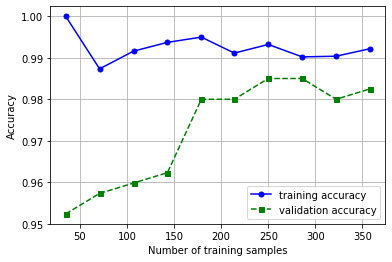

In [8]:
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

* train_sizes 파라미터를 통행 훈련세트의 비율을 0.1에서 1.0 사이로 총 10개를 생성
* cv 파라미터를 통해 10-fold CV를 설정
* train 정확도와 validataion 정확도를 시각화
* train 데이터의 비율이 0.7(250개) 이상일 경우에 모형의 성능이 좋다.

# 검증 곡선으로 과대적합과 과소적합 조사하기

validation_curve 함수 사용

In [9]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

In [10]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

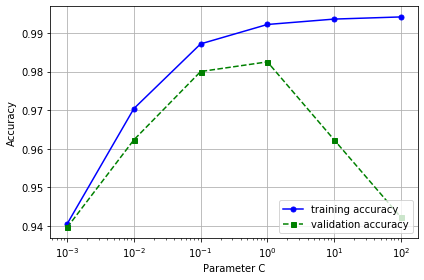

In [11]:
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')
plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
#plt.ylim([0.8, 1.00])
plt.tight_layout()
plt.show()

* validation_curve 함수는 기본적으로 CV를 통해 성능을 추정한다.
* validation_curve 함수 안에서 평가하고자 하는 파라미터를 지정한다. 
* param_name='logisticregression__C' --> 이 경우에는 logisticregression 모형의 C 파라미터를 의미한다.
* C의 값을 높일수록 규제가 약해지고 조금 과대 적합되는 경향이 보인다. 
* 이 경우 적합한 값은 0.01 또는 0.1 로 확인된다.

# confusion matrix
분류 모형의 성능을 평가한다. 
confusion_matrix 함수를 사용한다.

In [12]:
from sklearn.metrics import confusion_matrix

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[ 60   4]
 [  2 105]]


In [13]:
from sklearn.metrics import precision_score, recall_score

print('정밀도(Positive Predictive Value): %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율(sensitivity, True Positive Rate): %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('정확도: %.3f' % pipe_lr.score(X_test, y_test))

정밀도(Positive Predictive Value): 0.963
재현율(sensitivity, True Positive Rate): 0.981
정확도: 0.965


# ROC, AUC

* ROC(Receiver Operating Chracteristic) : 분류 모형의 FPR과 TPR 점수를 기반으로 분류 모형의 성능을 비교 할 때 유용하다.
* AUC(Area Under the Curve) : ROC 그래프의 아래 면적, 1에 가까울 수록 좋은 모형이다.

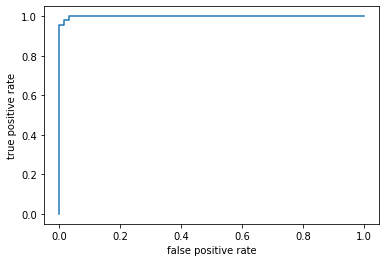

AUC : 0.999


In [16]:
from sklearn.metrics import roc_curve, auc

probas = pipe_lr.fit(X_test, y_test).predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test,
                                     probas[:, 1],
                                     pos_label=1)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr)

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

print('AUC : %.3f' % roc_auc)